## Importing Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from utils import dummify_dataframe , calculate_clv
from Exponential import ExponentialAFTFitter
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

## Reading & Preparing The Data

In [3]:
df = pd.read_csv('telco.csv')
df.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


#### Dummifying the categorical variables

In [34]:
data = dummify_dataframe(df)
data.head()

,ID,tenure,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,...,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn_Yes
0,1,13,44,9,64,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,2,11,33,7,136,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,1
2,3,68,52,24,116,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,4,33,33,12,33,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
4,5,23,30,9,30,1,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


#### Replacing zeros in 'tenure' column.

In [35]:
# This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.
data["tenure"] = np.where(data["tenure"] == 0, 0.0001, data["tenure"])

#### Choosing Meaningful Columns

In [36]:
data = data.drop(columns=["ID", "address"])

## Building Accelerated Failure Time (AFT) Models

* ###  Weibull

In [37]:
# AFT model with Weibull distribution
weibull_model = WeibullAFTFitter()
weibull_model.fit(data, duration_col='tenure', event_col='churn_Yes')
weibull_prediction = weibull_model.predict_survival_function(data).T
weibull_prediction_avg = weibull_prediction.mean()

* ###  Log-Normal

In [38]:
# AFT model with Log-Normal distribution
lognormal_model = LogNormalAFTFitter()
lognormal_model.fit(data, duration_col='tenure', event_col='churn_Yes')
lognormal_prediction = lognormal_model.predict_survival_function(data).T
lognormal_prediction_avg = lognormal_prediction.mean()

* ###  Log-Logistic

In [39]:
# AFT model with Log-Logistic distribution
loglogistic_model = LogLogisticAFTFitter()
loglogistic_model.fit(data, duration_col='tenure', event_col='churn_Yes')
loglogistic_prediction = loglogistic_model.predict_survival_function(data).T
loglogistic_prediction_avg = loglogistic_prediction.mean()

* ###  Exponential

In [40]:
# AFT model with Exponential distribution (special case of Weibull with α=1)
exponential_model = ExponentialAFTFitter()
exponential_model.fit(data, duration_col='tenure', event_col='churn_Yes')
exponential_prediction = exponential_model.predict_survival_function(data).T
exponential_prediction_avg = exponential_prediction.mean()

## Comparing the Models

* AIC/BIC

In [41]:
print("AIC:", weibull_model.AIC_, "BIC:", weibull_model.BIC_)
print("AIC:", lognormal_model.AIC_, "BIC:", lognormal_model.BIC_)
print("AIC:", loglogistic_model.AIC_, "BIC:", loglogistic_model.BIC_)
print("AIC:", exponential_model.AIC_, "BIC:", exponential_model.BIC_)

AIC: 2985.4663312289827 BIC: 2961.281841786947
AIC: 2975.4071829980458 BIC: 2951.22269355601
AIC: 2974.594136116568 BIC: 2950.4096466745323
AIC: 3051.961015457222 BIC: 3024.868770736204


AIC and BIC offer a trade-off between model fit and complexity. A model with a lower AIC or BIC is generally preferred.  
*We can observe that **Log-Logistic** has the lowest AIC and BIC scores among all the models, however, **Log-Normal** does not fall much behind.*


## Plotting Survival Curves

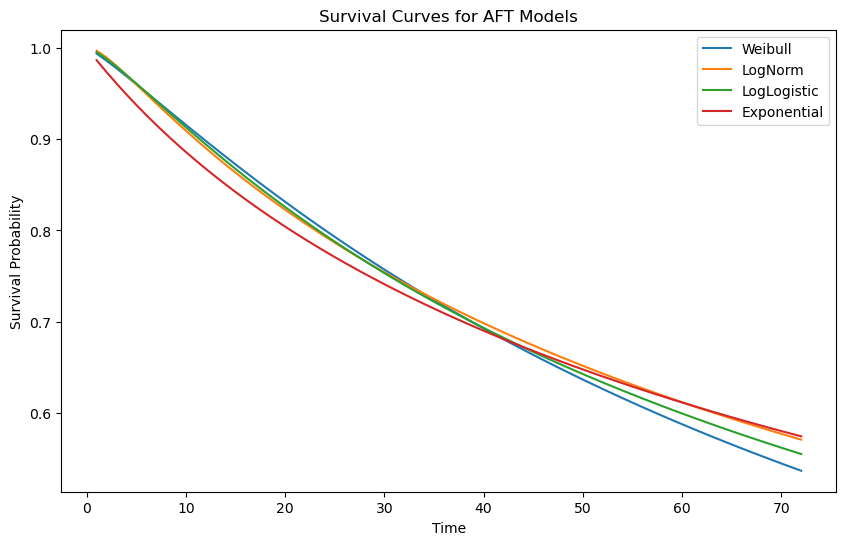

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(weibull_prediction_avg, label='Weibull')
plt.plot(lognormal_prediction_avg, label='LogNorm')
plt.plot(loglogistic_prediction_avg, label='LogLogistic')
plt.plot(exponential_prediction_avg, label='Exponential')

plt.title('Survival Curves for AFT Models')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

## Choosing & Building Optimal AFT Model

* Firstly, we saw that Log-Logistic and Log-Normal models displayed best performance in terms of **AIC/BIC** scores.
* In terms of **complexity**, the Exponential model is the simplest, assuming a constant hazard over time. The Weibull model adds flexibility by allowing for different hazard shapes. The Log-Normal and Log-Logistic models provide further flexibility in capturing various shapes of the survival curve. Choosing between these models often involves a trade-off between simplicity and the ability to capture complex patterns in the data.  
*Given the fact that we are working with a fairly small dataset, let's prioritize model performance and continue with **Log-Logistic** model!*

### Log-Logistic Model - All Auxiliary Features Included. 

In [43]:
loglogistic_model.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1468.30
         time fit was run = 2023-11-26 21:02:35 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
alpha_ age                               0.05       1.05       0.01             0.04             0.06                 1.04                 1.06
       custcat_E-service                 1.10       2.99       0.17             0.77             1.42                 2.16                 4.15
       custcat_Plus service              0.89       2.43       0.21             0.47             1.30                 1.61                 3.67
       custcat_Total service             1.26       3.53       0.24             0.78             1.74                 2.19                 5.68
       ed_Did not complete high school   0.49       1.63       0.20             0.10             0.88                 1.10                 2.42
       ed_High school degree             0.36       1.44       0.16             0.06             0.67                 1.06                 1.95
       ed_Post-undergraduate degree      0.01       1.01       0.22            -0.41             0.44                 0.66                 1.55
       ed_Some college                   0.25       1.29       0.16            -0.06             0.56                 0.95                 1.75
       forward_Yes                      -0.15       0.86       0.17            -0.48             0.19                 0.62                 1.21
       gender_Male                       0.03       1.03       0.11            -0.19             0.24                 0.83                 1.28
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.83       0.44       0.14            -1.11            -0.55                 0.33                 0.58
       marital_Unmarried                -0.42       0.66       0.11            -0.64            -0.20                 0.53                 0.82
       region_Zone 2                    -0.04       0.96       0.14            -0.31             0.23                 0.74                 1.26
       region_Zone 3                     0.12       1.13       0.14            -0.15             0.39                 0.86                 1.48
       retire_Yes                        0.01       1.01       0.48            -0.92             0.95                 0.40                 2.57
       voice_Yes                        -0.46       0.63       0.16            -0.78            -0.13                 0.46                 0.87
       Intercept                         1.96       7.08       0.27             1.42             2.49                 4.15                12.05
beta_  Intercept                         0.32       1.38       0.05             0.22             0.42                 1.25                 1.53

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
alpha_ age                                 0.00  8.37 <0.005      53.92
       custcat_E-service                   0.00  6.57 <0.005      34.18
       custcat_Plus service                0.00  4.21 <0.005      15.29
       custcat_Total service               0.00  5.17 <0.005      22.02
       ed_Did not complete high school     0.00  2.44   0.01       6.08
       ed_High school degree               0.00  2.32   0.02       5.63
       ed_Post-undergraduate degree        0.00  0.05   0.96

### Log-Normal Model - Only Significant Auxiliary Features Included. 

*To determine significant variables, we must consider p_value. If a predictor variable has a p-value > alpha (= 0.01), it is considered non-significant and can be removed from the model.*

In [44]:
significant_features = loglogistic_model.summary[loglogistic_model.summary['p'] < 0.01].index
significant_features

MultiIndex([('alpha_',                   'age'),
            ('alpha_',     'custcat_E-service'),
            ('alpha_',  'custcat_Plus service'),
            ('alpha_', 'custcat_Total service'),
            ('alpha_',          'internet_Yes'),
            ('alpha_',     'marital_Unmarried'),
            ('alpha_',             'voice_Yes'),
            ('alpha_',             'Intercept'),
            ( 'beta_',             'Intercept')],
           names=['param', 'covariate'])

We can see that Age, Customer Category, Internet and Voice Incuded, and Marital Status are the significant features.

In [45]:
final = data[['churn_Yes','tenure', 'age', 'marital_Unmarried','internet_Yes', 'voice_Yes', 
              'custcat_E-service','custcat_Plus service','custcat_Total service' ]]

In [46]:
logl_aft_final = LogLogisticAFTFitter()
logl_aft_final.fit(final, duration_col='tenure', event_col='churn_Yes')
logl_aft_final_pd = logl_aft_final.predict_survival_function(final).transpose()
logl_aft_final.print_summary() 

<lifelines.LogLogisticAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1474.33
         time fit was run = 2023-11-26 21:02:54 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
alpha_ age                     0.06       1.06       0.01             0.04             0.07                 1.05                 1.07
       custcat_E-service       1.03       2.81       0.17             0.71             1.36                 2.03                 3.89
       custcat_Plus service    0.80       2.22       0.17             0.46             1.13                 1.59                 3.10
       custcat_Total service   1.10       3.01       0.21             0.69             1.51                 2.00                 4.52
       internet_Yes           -0.93       0.39       0.14            -1.20            -0.66                 0.30                 0.52
       marital_Unmarried      -0.41       0.66       0.11            -0.63            -0.19                 0.53                 0.83
       voice_Yes              -0.50       0.61       0.16            -0.82            -0.18                 0.44                 0.83
       Intercept               2.21       9.07       0.22             1.76             2.65                 5.84                14.09
beta_  Intercept               0.31       1.36       0.05             0.21             0.41                 1.23                 1.51

                               cmp to     z      p   -log2(p)
param  covariate                                             
alpha_ age                       0.00 10.57 <0.005      84.35
       custcat_E-service         0.00  6.22 <0.005      30.94
       custcat_Plus service      0.00  4.67 <0.005      18.32
       custcat_Total service     0.00  5.30 <0.005      23.06
       internet_Yes              0.00 -6.64 <0.005      34.92
       marital_Unmarried         0.00 -3.64 <0.005      11.86
       voice_Yes                 0.00 -3.07 <0.005       8.88
       Intercept                 0.00  9.82 <0.005      73.18
beta_  Intercept                 0.00  6.05 <0.005      29.34
---
Concordance = 0.77
AIC = 2966.66
log-likelihood ratio test = 261.76 on 7 df
-log2(p) of ll-ratio test = 172.94

### Interpreting Coefficients
1.  For 'age' variable, an exp(coef) of 1.06 means that, for each additional unit increase in age, the hazard of the event (e.g., churn) is expected to increase by approximately 6% holding other variables constant. Thus, more loyal are those with a **lower age**.
2.  For 'internet_Yes' variable, an exp(coef) of 0.39 means that having internet included decreases the hazard of the event (e.g., churn) by approximately 61% holding other variables constant. Thus, the more loyal customers are those who have **internet included**.
3.  For 'voice_Yes' variable, an exp(coef) of 0.61 means that having voice included decreases the hazard of the event (e.g., churn) by approximately 39% holding other variables constant. Thus, the more loyal customers are those who have **voice included**.
4.  For 'marital_Unmarried' variable, an exp(coef) of 0.66 means that being unmarried decreases the hazard of the event (e.g., churn) by approximately 34% holding other variables constant. Thus, the more loyal customers are those are **not married**.
5. Basic Service is the reference category for the Customer Category variable. The exp(coef) of 'custcat_E-service'	is 2.81, which implies that, compared to the reference category (basic service), individuals with e-service are expected to have a hazard of the event (e.g., churn) that is approximately 2.81 times higher.  The exp(coef) of 'custcat_Plus-service' is 2.22, which implies that, compared to the reference category (basic service), individuals with e-service are expected to have a hazard of the event (e.g., churn) that is approximately 2.22 times higher.  The exp(coef) of 'custcat_Total-service' is 3.01, which implies that, compared to the reference category (basic service), individuals with e-service are expected to have a hazard of the event (e.g., churn) that is approximately 3.01 times higher. Thus, more loyal customers are those with **basic service**. 

## CLV Calculation

In [48]:
calculate_clv(logl_aft_final_pd, df)
df.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn,CLV
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes,46578.868165
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes,46548.960131
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No,53103.215348
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes,34624.861584
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No,46816.584276


## Exploring CLV within different segments.

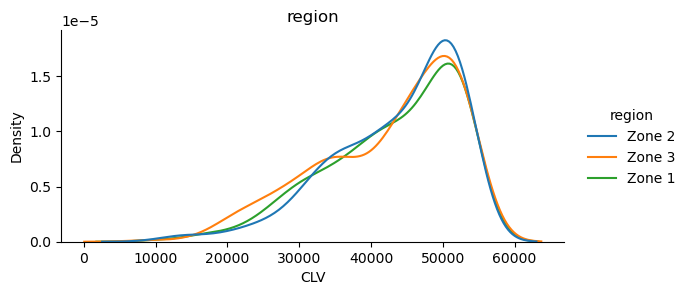

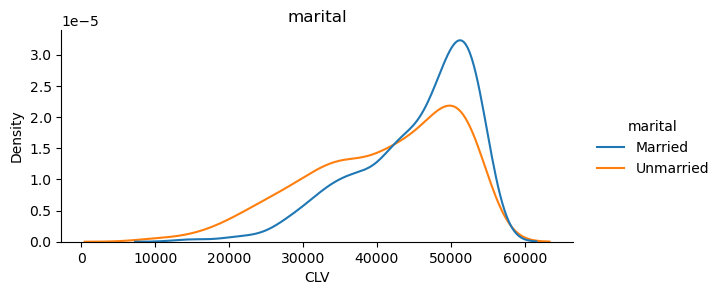

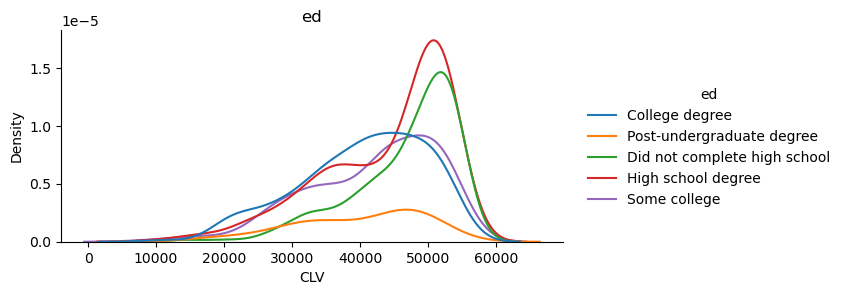

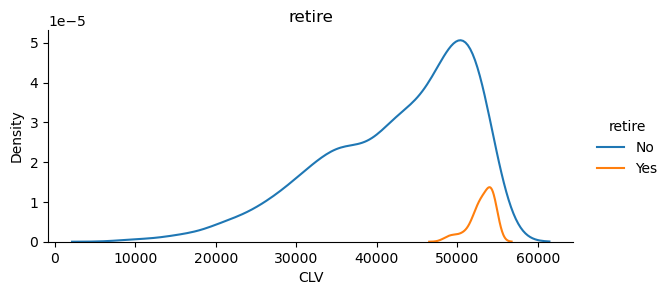

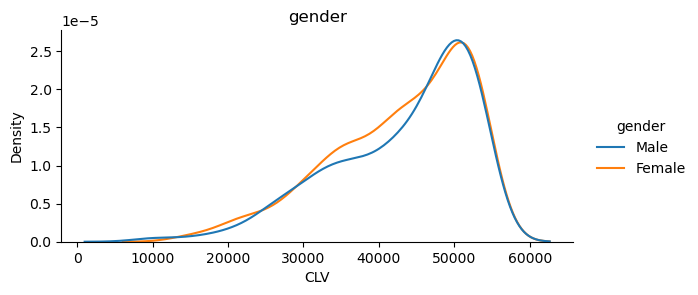

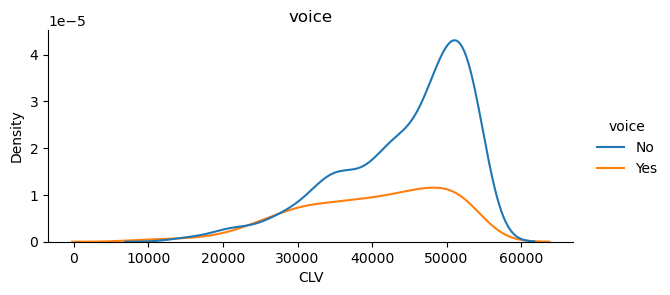

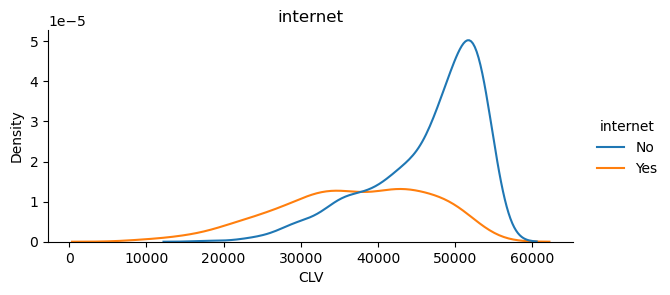

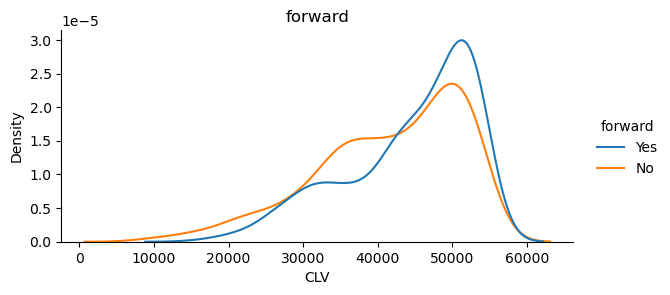

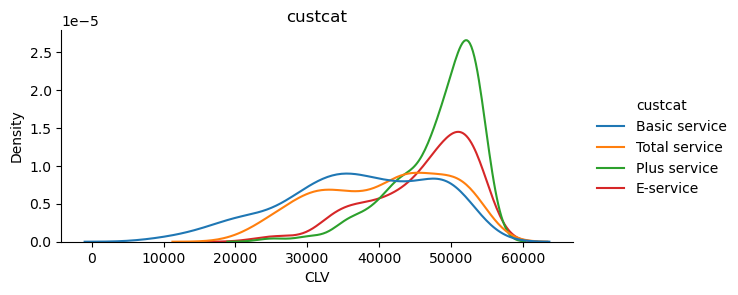

In [61]:
segments = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']
for column in segments:
    sns.displot(df, kind='kde', x='CLV', hue=column, height = 3, aspect = 2)
    plt.title(column)

In [67]:
for col in segments:
    print(df.groupby(col)[["CLV"]].mean())


                 CLV
region              
Zone 1  43016.338867
Zone 2  43468.531147
Zone 3  42400.563180
                    CLV
marital                
Married    45123.889187
Unmarried  40830.136841
                                       CLV
ed                                        
College degree                40332.122205
Did not complete high school  46697.645318
High school degree            43934.844940
Post-undergraduate degree     39750.340285
Some college                  41907.583994
                 CLV
retire              
No      42456.290681
Yes     53078.707095
                 CLV
gender              
Female  42809.646745
Male    43111.711977
                CLV
voice              
No     44292.407839
Yes    39894.830250
                   CLV
internet              
No        46477.357718
Yes       36907.212431
                  CLV
forward              
No       41583.172124
Yes      44366.888408
                        CLV
custcat                    
Basic service 

### Important Findings

Let's consider the most valuable segments as those contributing the highest average Customer Lifetime Value (CLV) to the company.

1. Retired customers emerge as particularly valuable, having a significantly higher average CLV than non-retired customers. Although constituting a smaller portion of our customer base, their elevated CLV positions them as high-value customers worthy of strategic attention.

2. The second-highest average CLV is attributed to customers utilizing the Plus Service. However, despite their financial contribution, it's noteworthy that they exhibit a higher likelihood of churning compared to Basic Service customers (as displayed by model coefficients). This highlights the importance of focusing efforts on retaining Plus Service customers, given their value and vulnerability.

3. Customers who did not complete high school claim the third position in terms of average CLV. 

The elevated CLV associated with Plus Service customers aligns with their higher expenditures for additional features and enhanced service. Regarding the other two segments, these findings may be linked to the higher demands that more educated or younger individuals have from a telecom company.

### Retention Budget Calculation

Let's consider the customer's who have not churned yet our at-risk customers.

In [70]:
retained_customers = df[df['churn'] == 'No']
at_risk_subscribers = len(retained_customers)

#let's see on average CLV the retained customers can generate in their entire lifetime.
retained_clv = retained_customers['CLV'].mean()
retained_clv 

44889.94570821102

Let's compute the annual budget.

In [71]:
#assume our goal is to retain 85% of at-risk customers
retention_rate = 0.85 

#assume we are prepared to pay 0.25 percent of the each customers CLV to retain them
cost_per_customer = retained_clv * 0.25

retention_budget = at_risk_subscribers * retention_rate * cost_per_customer
print(f'Yearly Retention Budget: {retention_budget}')

Yearly Retention Budget: 6925396.374134255


### Retention Strategies

* Implement loyalty programs, offering rewards and exclusive perks to long-term subscribers, fostering a sense of value and appreciation.
* Regularly communicate with customers through targeted and engaging content, informing them about new features, promotions, and benefits. 
* Utilize data analytics to identify potential churn indicators and proactively address issues before they escalate. 
* Consider flexible subscription plans, ensuring that offerings align with evolving customer needs.
* Finally, actively seek and act upon customer feedback, demonstrating a commitment to continuous improvement and a customer-centric approach.